## THIS PROGRM NEED cifar-10-batches-py IN THE SAME DIRECTORY

AND cifar-10-batches-py HAS THE FOLLOWING CONTENTS will be override except the two files:

- `batches.meta` 
- `test_batch`
- data_batch_1  
- data_batch_2  
- data_batch_3  
- data_batch_4  
- data_batch_5

In [1]:
import torch
import os
from collections import Counter
import numpy as np
import pickle
import copy
from torch.utils.data import Dataset
from PIL import Image
import tarfile
import shutil
from typing import Any, Callable, Optional, Tuple
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10, CIFAR100, SVHN, FashionMNIST, MNIST


## Partition Data

In [2]:
def partition_data(dataset, datadir, partition, n_parties, beta=0.4):
    if dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == 'cifar100':
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == 'tinyimagenet':
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)

    n_train = y_train.shape[0]

    if partition == "homo" or partition == "iid":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}


    elif partition == "noniid-labeldir" or partition == "noniid":
        min_size = 0
        min_require_size = 10
        K = 10
        if dataset == 'cifar100':
            K = 100
        elif dataset == 'tinyimagenet':
            K = 200
            # min_require_size = 100

        N = y_train.shape[0]
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
                # if K == 2 and n_parties <= 10:
                #     if np.min(proportions) < 200:
                #         min_size = 0
                #         break

        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map)
    return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

def load_cifar10_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])

    cifar10_train_ds = CIFAR10_truncated(datadir, train=True, download=True, transform=transform)
    cifar10_test_ds = CIFAR10_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (X_train, y_train, X_test, y_test)

def load_cifar100_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])

    cifar100_train_ds = CIFAR100_truncated(datadir, train=True, download=True, transform=transform)
    cifar100_test_ds = CIFAR100_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = cifar100_train_ds.data, cifar100_train_ds.target
    X_test, y_test = cifar100_test_ds.data, cifar100_test_ds.target

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (X_train, y_train, X_test, y_test)

def record_net_data_stats(y_train, net_dataidx_map):
    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    data_list=[]
    for net_id, data in net_cls_counts.items():
        n_total=0
        for class_id, n_data in data.items():
            n_total += n_data
        data_list.append(n_total)
    print('mean:', np.mean(data_list))
    print('std:', np.std(data_list))
    print('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [3]:
def get_dataloader(dataset, datadir, train_bs, test_bs, dataidxs=None, noise_level=0):
    if dataset in ('cifar10', 'cifar100'):
        if dataset == 'cifar10':
            dl_obj = CIFAR10_truncated

        train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, download=False)
        test_ds = dl_obj(datadir, train=False, download=False)

        train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=False, shuffle=False)
        test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)

    elif dataset == 'tinyimagenet':
        dl_obj = ImageFolder_custom
    
        train_ds = dl_obj(datadir+'./train/', dataidxs=dataidxs)
        test_ds = dl_obj(datadir+'./val/')

        train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, drop_last=False, shuffle=True)
        test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)


    return train_dl, test_dl, train_ds, test_ds

In [4]:
class CIFAR10_truncated(torch.utils.data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        if torchvision.__version__ == '0.2.1':
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(cifar_dataobj.train_labels)
            else:
                data, target = cifar_dataobj.test_data, np.array(cifar_dataobj.test_labels)
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [5]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
################# the alpha controlls the partition ###################### 
alpha = 0.5
all_clients = 10

X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts = partition_data(
"cifar10", "../data", "noniid", all_clients, beta=alpha)

Files already downloaded and verified
Files already downloaded and verified
mean: 5000.0
std: 1165.398901664147
Data statistics: {0: {0: 953, 1: 142, 2: 141, 3: 75, 4: 695, 5: 819, 7: 2482}, 1: {0: 16, 1: 43, 2: 902, 3: 1650, 4: 86, 5: 182, 7: 693, 8: 110, 9: 6}, 2: {0: 9, 1: 8, 2: 290, 3: 769, 4: 841, 5: 283, 6: 119, 7: 1044, 8: 1014, 9: 58}, 3: {0: 395, 1: 1200, 2: 48, 3: 68, 4: 896, 5: 681, 6: 90, 7: 17, 8: 1351, 9: 301}, 4: {0: 504, 1: 2917, 2: 570, 3: 721, 4: 121, 5: 356}, 5: {0: 1262, 1: 71, 2: 325, 3: 119, 4: 1560, 5: 14, 6: 1, 7: 85, 8: 366}, 6: {0: 9, 1: 273, 2: 1657, 3: 40, 4: 1, 5: 130, 6: 1911, 7: 21, 8: 1160}, 7: {0: 722, 1: 3, 2: 281, 3: 738, 4: 22, 5: 974, 6: 624, 7: 1, 8: 82, 9: 878}, 8: {0: 1127, 1: 153, 2: 680, 3: 500, 4: 698, 5: 1139, 6: 92, 7: 23, 8: 1, 9: 3665}, 9: {0: 3, 1: 190, 2: 106, 3: 320, 4: 80, 5: 422, 6: 2163, 7: 634, 8: 916, 9: 92}}


In [6]:
copy_sta = copy.deepcopy(traindata_cls_counts)

In [7]:
with open("traindata_cls_counts.pkl","wb") as file:
    pickle.dump(traindata_cls_counts,file)

In [8]:
!pwd

/home/aikedaer/Desktop/DatasetCondensation (copy)/ipynb


In [9]:
with open("traindata_cls_counts.pkl","rb") as file:
    stat = pickle.load(file)
stat[0]

{0: 953, 1: 142, 2: 141, 3: 75, 4: 695, 5: 819, 7: 2482}

In [14]:
## put the data that after partition into disk from memory, so CAREFULLY DO IT TO NOT OVERWRITE THE EXISTING DATA
## WARNING: CHECK HTE PATH NO DATA
keep_avg_align = False
for client in range(10):
    
    ## ds mean all the data, only dl is related to batchsize
    train_dl_local, test_dl_local, train_ds, test_ds = get_dataloader("cifar10", 
                                                                      '../data', 64, 32,
                                                                      dataidxs=net_dataidx_map[client])


    transform_type = torchvision.transforms.Compose([
        transforms.ToTensor()
    ])
    
    data_ = [transform_type(i) for i in train_ds.data]
    data_ = np.vstack(data_).reshape(-1, 3, 32, 32).transpose((0,2,3,1))
    labels_=list(train_ds.target)
    origin_lab = np.array(labels_)
    
    transform_aug = torchvision.transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(32),
        torchvision.transforms.ToTensor()
    ])
    # i stands for labels
    for i in range(10):
        data_index = np.argwhere(origin_lab==i).reshape(-1)
        if i not in Counter(train_ds.target).keys():
            # add 20 noise to those who lossing classes
            for j in range(20):
                t_d = data_[0].shape
                noise = torch.randn(t_d).reshape((1,32,32,3)).numpy()
                data_=np.concatenate((data_, noise))
                labels_.append(i)
                copy_sta[client][i] = 1 if j==0 else copy_sta[client][i]+1
        elif traindata_cls_counts[client][i]<20:
            # add 10 aug images to those who has less than 10 images' classes, switch to dataset using transform
            num_da = traindata_cls_counts[client][i]
            while copy_sta[client][i]<20:
                for j in data_index:
                    aug = transform_aug(data_[j]).cpu().numpy().transpose((1,2,0)).reshape((1,32,32,3))
                    
                    data_=np.concatenate((data_, aug))
                    labels_.append(i)
                    copy_sta[client][i]+=1
        ### keep align with the avg num class
        if keep_avg_align:
            data_index_new = np.argwhere(np.array(labels_)==i).reshape(-1)
            mean_num_client = int(np.array(list(traindata_cls_counts[client].values())).mean())
            while copy_sta[client][i] < mean_num_client:
                choice_index = np.random.choice(data_index_new)
                aug = transform_aug(data_[choice_index]).cpu().numpy().transpose((1,2,0)).reshape((1,32,32,3))
                data_=np.concatenate((data_, aug))
                labels_.append(i)
                copy_sta[client][i]+=1
                
            
    num = data_.shape[0]
    step = num//5
    data_ = data_.reshape(num,-1)
    os.makedirs("cifar-10-batches-py",exist_ok=True)
    for i in range(5):
        dic = {}
        dic['data']=data_[step*i:step*(i+1)]
        dic['labels']=labels_[step*i:step*(i+1)]
        with open("cifar-10-batches-py/data_batch_"+str(i+1),"wb") as f:
            pickle.dump(dic,f)

    # compress file to tar.gz
    def Converter(path, tar):
        with tarfile.open(tar, "w:gz") as t:
            for root, dirs, files in os.walk(path):
                for file in files:
                    t.add(os.path.join(root, file))

    Converter("cifar-10-batches-py", "cifar-10-python.tar.gz")
    # move to new dir
    ne_path = "data/cifar10/avg-align-alpha-"+str(alpha)+"/partition_client_"+str(client+1)
    os.makedirs(ne_path) #,exist_ok=True) in order to not override the origional data
    shutil.move("cifar-10-python.tar.gz",ne_path)

In [243]:
os.getcwd()

'/home/aikedaer/Desktop/FedMOON/ipynb'

In [4]:
## uncompress
import subprocess
current_dir = os.getcwd()
print(current_dir)
for client in range(10):
    xpath = "data/cifar10/avg-align-alpha-"+str(alpha)+"/partition_client_"+str(client+1)
    os.chdir(xpath)
    subprocess.run(["tar","-xzvf","cifar-10-python.tar.gz"])
    os.chdir(current_dir)

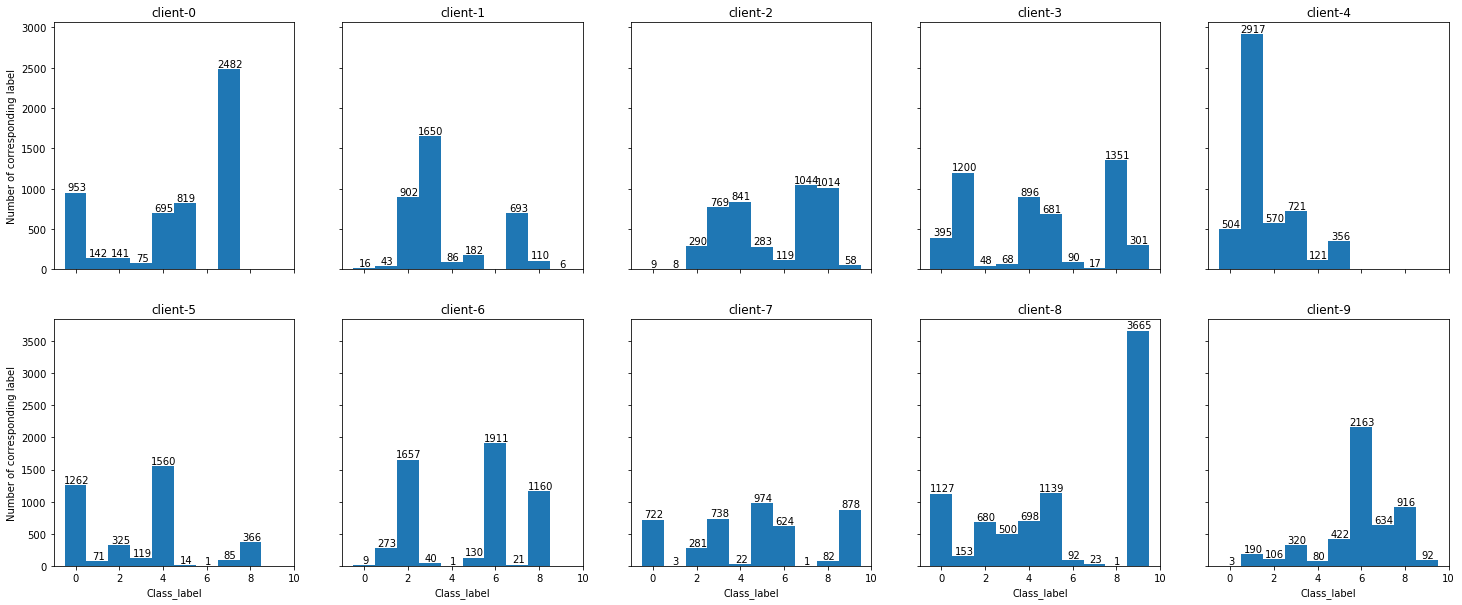

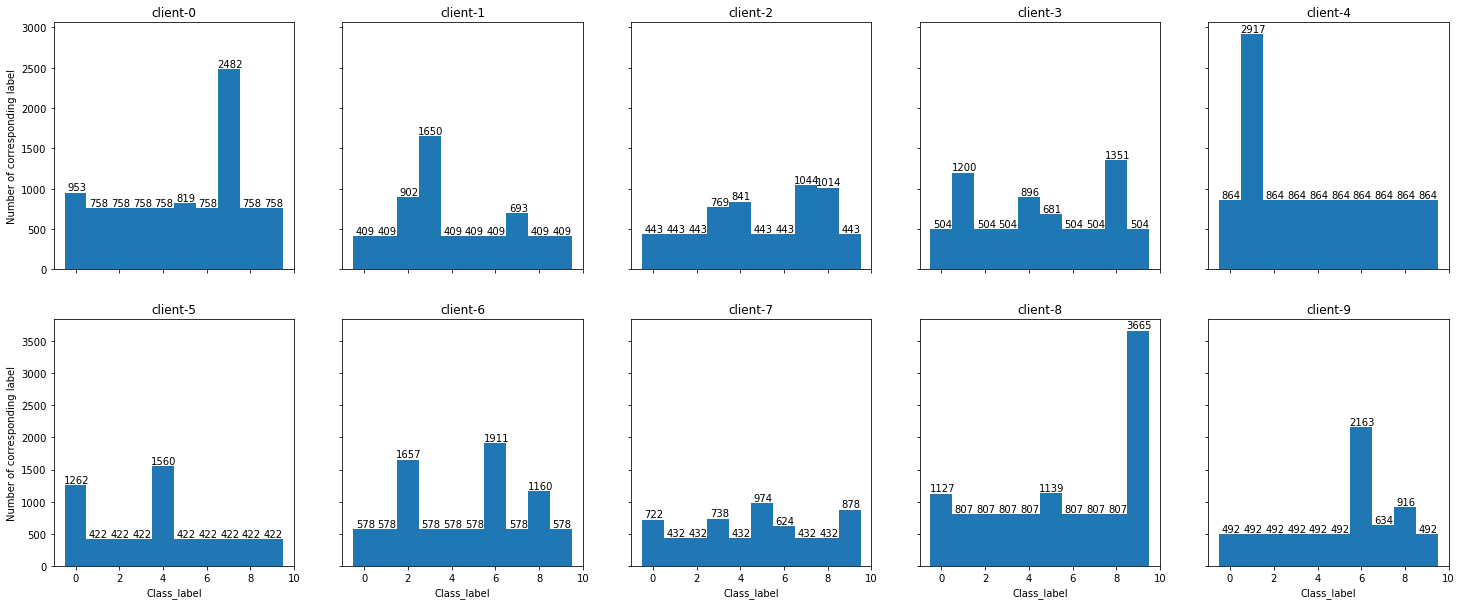

In [17]:
## related to the partition alpha 
import matplotlib.pyplot as plt
for flag in ["former","augmentation"]:
    if flag == "former":
        x = traindata_cls_counts
    else:
        x = copy_sta
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row',figsize=(25,10))
    for i in range(10):
        if i==0:
            ax[i//5,i%5].set_ylabel("Number of corresponding label")
        elif i>5:
            ax[i//5,i%5].set_xlabel("Class_label")
        elif i==5:
            ax[i//5,i%5].set_ylabel("Number of corresponding label")
            ax[i//5,i%5].set_xlabel("Class_label")

        ax[i//5,i%5].set_xlim(-1,10)
        ax[i//5,i%5].bar(list(x[i].keys()),list(x[i].values()),width = 1)
        ax[i//5,i%5].set_title("client-{0}".format(i))
        for m,n in zip(list(x[i].keys()),list(x[i].values())):
            ax[i//5,i%5].text(m+0.05,n+0.05,'%d' %n, ha='center',va='bottom')
    # plt.title("partition-"+str(alpha)) not work
    plt.savefig("data/cifar10/avg-align-alpha-"+str(alpha)+"/"+flag+"_partition.png",dpi=330)
    plt.show()

## Create DataSet

In [84]:
class MYCIFAR10(Dataset):
    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:

        #         super().__init__(root, transform=transform, target_transform=target_transform)
        self.root = root
        self.train = train  # training set or test set
        self.transform = transform
        self.target_transform = target_transform
        self.downlod = download

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 32, 32, 3)

        self._load_meta()

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        if not (isinstance(img, torch.Tensor) or isinstance(img, np.ndarray)):
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)



In [85]:
client = 1
data_path = "data/avg-align-alpha-0.5/partition_client_"+str(client)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
dst_train = MYCIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor()) # no augmentation
# dst_test = MYCIFAR10(data_path, train=False, download=True, transform=transform)


## Create DataLoader

In [86]:
testloader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=False, num_workers=0)

## Visualize The Raw Data Ready To Distill

In [87]:
vis_train = MYCIFAR10(data_path, train=True, transform=transforms.ToTensor())
vis_train[0][0].shape

torch.Size([3, 32, 32])

In [2]:
x = next(iter(testloader))[0][0]
transforms.ToPILImage()(x).resize((256,256))

In [1]:
for i in range(3740):
    display(transforms.ToPILImage()(vis_train[i][0]).resize((256,256)))

## Create Data-Condensation

In [132]:
class CIFAR10_DIST(torch.utils.data.Dataset):

    def __init__(self, root, client_num, experiment):
        self.root = root
        self.client_num = client_num
        self.experiment = experiment
        self.mean = [0.4914, 0.4822, 0.4465]
        self.std = [0.2023, 0.1994, 0.2010]
        self.train_ds_list = []
        self.train_ds_label_list = []
        normalize = transforms.Normalize(self.mean,self.std)
        transform_train = transforms.Compose([transforms.ToTensor(), normalize])
        # transform_train = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Lambda(lambda x: F.pad(
        #         Variable(x.unsqueeze(0), requires_grad=False),
        #         (4, 4, 4, 4), mode='reflect').data.squeeze()),
        #     transforms.ToPILImage(),
        #     transforms.ColorJitter(brightness=0),
        #     transforms.RandomCrop(32),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.ToTensor(),
        #     normalize
        # ])

        self.data = self._constract()
        self.target = self.train_ds_label_list

        self.transform = transform_train
        self.target_transform = None


    def _constract(self):
        for j in range(self.client_num):
            if self.client_num !=1:
                res = torch.load(os.path.join(self.root, "client_" + str(j + 1), "res_DM_CIFAR10_ConvNet_1ipc_"+ str(self.experiment) +"_experiment.pt"))
            else:
                res = torch.load(os.path.join(self.root, "res_DM_CIFAR10_ConvNet_1ipc.pt"))
            # how many data
            if self.client_num !=1:
                num_data = len(res['data'][0][0])
            else:
                num_data = 100
            for i in range(num_data):
                if self.client_num != 1:
                    if (res['data'][0][0][i] == torch.zeros((3, 32, 32)))[0][0][0] == True:
                        continue
                    image_syn_vis = res['data'][0][0][i]
                else:
                    image_syn_vis = res[0][i]
                # for ch in range(3):
                #     image_syn_vis[:, ch] = image_syn_vis[:, ch] * self.std[ch] + self.mean[ch]
                # image_syn_vis[image_syn_vis < 0] = 0.0
                # image_syn_vis[image_syn_vis > 1] = 1.0
                self.train_ds_list.append(np.array(image_syn_vis))
                if self.client_num != 1:
                    self.train_ds_label_list.append(res['data'][0][1][i])
                else:
                    self.train_ds_label_list.append(res[1][i])

        train_ds = np.vstack(self.train_ds_list).reshape((-1, 3, 32, 32))
        train_ds = train_ds.transpose((0, 2, 3, 1))

        return train_ds

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)



In [133]:
dis = CIFAR10_DIST(root="../res_hist",client_num=10,experiment=0)
train_dl = torch.utils.data.DataLoader(dataset=dis, batch_size=256, drop_last=False, shuffle=False)

KeyError: 0

In [3]:
res = torch.load("../res_hist/res_DM_CIFAR10_ConvNet_1ipc.pt")
res

In [ ]:
# train fednew
# writer = SummaryWriter("logs")
    
for epoch in range(100):
    epoch_loss_collector = []
    for batch_idx, (x, target) in enumerate(train_dl):
        x, target = x.cuda(), target.cuda()

        optimizer.zero_grad()
        x.requires_grad = False
        target.requires_grad = False
        target = target.long()

        _, _, out = net(x)
        loss = criterion(out, target)

        loss.backward()
        optimizer.step()

        epoch_loss_collector.append(loss.item())

    epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
    print('Epoch: %d Loss: %f' % (epoch, epoch_loss))


# net.cuda()
# train_acc, train_loss = compute_accuracy(net, train_dl_global, device=device)
# test_acc, conf_matrix, _ = compute_accuracy(net, test_dl, get_confusion_matrix=True, device=device)
# net.to('cpu')

# print('>> Global Model Test accuracy: %f' % test_acc)
# writer.add_scalar("Test_Acc", test_acc, round)